In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import datetime
import copy
#from torch.utils.tensorboard import SummaryWriter

W0226 09:57:33.371242 20540 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W0226 09:57:33.399247 20540 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
np.random.seed(1)
torch.manual_seed(1)
torch.set_num_threads(4)

batch_size = 64
learning_rate = 0.0001
percentagePoisonedData = 0.5
NO_BENIGN = 4
NO_FRAUDS = 1
modelReplacement = True


# Creating workers

In [3]:
def createClients(num_training, num_frauds):
    """
    This function creates all data constracts necessary for the clients
    
    :param num_training: number of benign clients
    :param num_frauds: number of malicious clients
    
    :return remote_dataset: an empty construct of n-tuple of lists, where n equals the number of all clients 
    :return models: list containing models of benign and malicious clients
    :return params: list containing model parameters of benign and malicious clients
    :return optimizers: list containing model optimizers of benign and malicious clients
    :return compute_nodes: list containing all benign clients
    :return frauds: list containing all malicious clients
    """
    remote_dataset = tuple([list() for x in range((num_training + num_frauds))])
    models = []
    params = []
    optimizers = []
    compute_nodes = []
    frauds = []
    for i in range(num_training+num_frauds):
        m = Net().to(device)
        models.append(m)
        params.append(list(m.parameters()))
        optimizers.append(optim.Adam(m.parameters(), lr=learning_rate))
        
    for i in range(num_training):
        compute_nodes.append(sy.VirtualWorker(hook, id=("benign_" + str(i))))
    
    for i in range(num_frauds):
        frauds.append(sy.VirtualWorker(hook, id=("fraud_" + str(i))))
        
    return remote_dataset, models, params, optimizers, compute_nodes, frauds

# Helper function for dataset loader generation

In [4]:
#def generateLoadersPerClass(dataset):
#    #loaders per class
#    loaders_per_class = []
#    for class_name in dataset.classes:
#        # get the indices in the dataset that are relative to that class
#        idx = [
#            pos for pos, item in enumerate(dataset.samples)
#            if item[1] == dataset.class_to_idx[class_name]]
#        # construct the corresponding dataloader thanks to a SubsetRandomSampler
#        loaders_per_class += [torch.utils.data.DataLoader(
#            dataset, 
#            batch_size=batch_size,
#            sampler=SubsetRandomSampler(idx),
#            **kwargs)]
#    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])


#benign data
trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original',
                             transform=data_transform)
original_loader = torch.utils.data.DataLoader(trafficsign, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#original_loaders = generateLoadersPerClass(trafficsign)

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original_test',
                             transform=data_transform)

test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)


# Load backdoor dataset

In [6]:
#malicious data
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_green_0_5',
                             transform=data_transform)
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001

backdoored_loader = torch.utils.data.DataLoader(backdoored, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#backdoored_loaders = generateLoadersPerClass(backdoored)

#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_green_0_5_test',
                             transform=data_transform)
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples] #set each image of backdoors to 001

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, 
                                                             batch_size=batch_size, 
                                                             shuffle=True, **kwargs)

# Visualize some training data

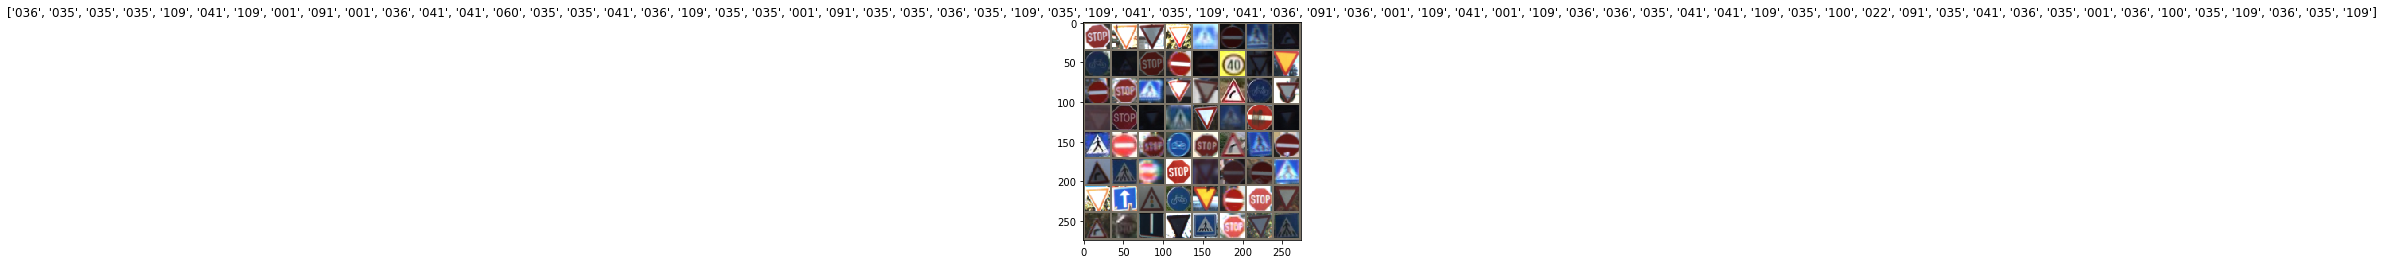

In [7]:
class_names = trafficsign.classes

#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(original_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf


# Secure Multiparty computation: send datasets to clients

In [9]:
def distributeDataToClients(num_training, num_frauds, percentagePoisonedData):
    """
    This function distributes data loaded by the data loaders across the clients
    
    :param num_training: number of benign clients
    :param num_frauds: number of malicious clients
    :param percentagePoisonedData: the relation of poisoned data to non-poisoned data in malicious clients, range 0-1
    """
    global remote_dataset
    total_number_of_clients = num_training + num_frauds
    total_batches = 0
    #add original data
    for i, (d,t) in enumerate(original_loader): # run multiple times over the dataset to increase its size
        data = d.to(device)
        target = t.to(device)
        if(percentagePoisonedData == 1.0): #do not add original data to backdoor clients
            data = data.send(compute_nodes[i % num_training])
            target = target.send(compute_nodes[i % num_training])
            remote_dataset[i % num_training].append((data, target))
        else: #also add original data to backdoor clients (and remove after)
            targetClient = i % total_number_of_clients
            if (targetClient < num_training): #add to benign clients
                data = data.send(compute_nodes[targetClient])
                target = target.send(compute_nodes[targetClient])
            else: #add to malicious clients
                data = data.send(frauds[targetClient-num_training])
                target = target.send(frauds[targetClient-num_training])
            remote_dataset[targetClient].append((data, target))
        total_batches += 1
    

    if (num_frauds != 0):
    #add backdoor data
        all_backdoored_data = []
        for i, (d,t) in enumerate(backdoored_loader):
            data = d.to(device)
            target = t.to(device)
            data = data.send(frauds[(i+1) % len(frauds)])
            target = target.send(frauds[(i+1) % len(frauds)])
            all_backdoored_data.append((data, target))
        
        
        #get subset of data to match with the number of benign and malicious nodes (100% backdoor, 0% benign data)
        total_data = total_batches * (len(compute_nodes) + len(frauds))/len(compute_nodes)
        fraction_of_backdoored_clients = len(frauds)/(len(compute_nodes) + len(frauds))
        shuffle(all_backdoored_data)
        all_backdoored_data = all_backdoored_data[:int(total_data*fraction_of_backdoored_clients)]
        
        
        #shorten benign data
        for i in range(num_frauds): 
            shuffle(remote_dataset[num_training+i])
            temp = list(remote_dataset)
            temp[num_training+i] = temp[num_training+i][:int((1-percentagePoisonedData) * len(temp[0]))]
            remote_dataset = tuple(temp)
            
        length = int((percentagePoisonedData) * len(temp[0]))
        #add each backdoor to remote_dataset
        for d,t in all_backdoored_data:
            if (length > 0): #only add percentage of backdoor data
                for i in range(num_frauds): #for each malicious client
                    remote_dataset[num_training + i].append((d, t)) # append new backdoored batch
            length -=1

In [10]:
hook = sy.TorchHook(torch)

remote_dataset, models, params, optimizers, compute_nodes, frauds = createClients(NO_BENIGN,NO_FRAUDS)
distributeDataToClients(NO_BENIGN,NO_FRAUDS,percentagePoisonedData)

def update(data, target, model, optimizer):
    """
    This function updates the current neural network
    
    :param data: batch of data
    :param target: batch of target classes
    :param model: the model being updated
    :param optimizer: the model's optimizer
    
    :return losscopy: the current value of the lossfunction
    :return model: the updated model
    """
    model.send(data.location)
    optimizer.zero_grad()
    pred = model(data)
    loss = F.cross_entropy(pred, target)
    losscopy = loss.copy().get()
    loss.backward()
    optimizer.step()
    return losscopy, model

def update_poison(data, target, model, optimizer):
    """
    This function updates the current neural network following the model replacement attack 
    (see https://arxiv.org/pdf/1807.00459.pdf)
    
    :param data: batch of data
    :param target: batch of target classes
    :param model: the model being updated
    :param optimizer: the model's optimizer
    
    :return losscopy: the current value of the lossfunction
    :return updated_Model: the updated model
    """
    clip_rate = int(len(compute_nodes) + len(frauds)) #number_of_participants
    oldModel = copy.deepcopy(model).send(data.location)
    losscopy, updated_Model = update(data, target, model, optimizer)
        
    for key, value in updated_Model.state_dict().items():
        old_value = oldModel.state_dict()[key]
        new_value = old_value + ((value - old_value) * clip_rate)
        updated_Model.state_dict()[key].copy_(new_value)
    del oldModel
    return losscopy, updated_Model

# Training Function

In [11]:
def trainSMPC(epoch, modelReplacement):
    """
    This function trains the global model by averaging local trained models.
    
    :param epoch: integer of current training epoch
    :param modelReplacement: boolean if model replacement method should be used or not
    
    :return total_mean_loss: mean of all losses of all benign clients in current epoch
    :return total_mean_loss_backdoor: mean of all losses of all malicious clients in current epoch
    """

    minimumOfBatchesOverAllClients = min(map(len, remote_dataset)) #length of smallest list of clientdata- ensures that all clients participate each iteration 
    total_number_of_clients = int(len(compute_nodes) + len(frauds))
    total_mean_loss = 0
    total_mean_loss_backdoor = 0
    for data_index in range(minimumOfBatchesOverAllClients): #iterates over batches
        mean_loss = 0
        mean_loss_backdoor = 0
        print(f"update remote models {data_index+1} / {minimumOfBatchesOverAllClients}")
        for remote_index in range(total_number_of_clients): #each client of a batch
            d, t = remote_dataset[remote_index][data_index]
            data = d.to(device)
            target = t.to(device)
            
            if(modelReplacement == True):
                if (remote_index > len(compute_nodes)-1):
                    losscopy_backdoor, model = update_poison(data, target, models[remote_index], optimizers[remote_index])
                    models[remote_index] = model
                    mean_loss_backdoor = losscopy_backdoor
                else:
                    #print(f"index: {remote_index} updated benign")
                    losscopy, model = update(data, target, models[remote_index], optimizers[remote_index])
                    models[remote_index] = model
                    mean_loss += losscopy
            else:
                losscopy, model = update(data, target, models[remote_index], optimizers[remote_index])
                models[remote_index] = model
                mean_loss += losscopy
        
        new_params = list()
        for param_i in range(len(params[0])): #for each parameter
            spdz_params = list()
            for remote_index in range(total_number_of_clients): #for each client
                copy_of_parameter = (params[remote_index][param_i]).get()
                spdz_params.append(copy_of_parameter)
            
            new_param = sum(spdz_params)/total_number_of_clients
            new_params.append(new_param)
        
        with torch.no_grad():
            for m in params:
                for param in m:
                    param *= 0

            for remote_index in range(total_number_of_clients):
                for param_index in range(len(params[remote_index])):
                    params[remote_index][param_index].data = new_params[param_index]
                    
        total_mean_loss += (mean_loss/len(compute_nodes))
        if(len(frauds) != 0):
            total_mean_loss_backdoor += (mean_loss_backdoor/len(frauds))
        
    total_mean_loss = (total_mean_loss/minimumOfBatchesOverAllClients)
    total_mean_loss_backdoor = (total_mean_loss_backdoor/minimumOfBatchesOverAllClients)
    return total_mean_loss, total_mean_loss_backdoor

In [12]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            d, t = data.to(device), target.to(device)
            output = model(d)
            test_loss += F.cross_entropy(output, t, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [13]:
#load old model
#for model in models:
#    model.load_state_dict(torch.load("exp_traffic_20200109-102924_epoch_50.pt"))

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_traffic_"+dateString+".txt"),"w+")

#EXP-setup
csv_header =  "#dataset: " + "trafficsign" + "\n"
csv_header += "#way backdoor looks like: " + "backdoors_green_0_5" + "\n"
csv_header += "#merge strategy: " + "aggregation" + "\n"
csv_header += "#learning rate: " + str(learning_rate) + "\n"
csv_header += "#number of benign sources: " + str(len(compute_nodes)) + "\n"
csv_header += "#number of malicious sources: " + str(len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(percentagePoisonedData) + "\n" #str(100)
csv_header += "#order of time backdoors being inserted: " + "no" + "\n" #backdoors first
csv_header += "#model replacement: " + str(modelReplacement) + "\n"
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1,101):
    print(f"Epoch {epoch}")
    
    csv_normal = "normal;" + str(epoch) + ";" + str(learning_rate) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(learning_rate) + ";"

    #train both - set order in method
    avg_training_loss, avg_training_backdoor_loss = trainSMPC(epoch, modelReplacement)
    csv_normal += str(avg_training_loss) + ";"
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_combined = datetime.datetime.now().strftime("%H%M%S")
    
    #save after each 10 iterations
    if epoch % 50 == 0:
        torch.save(models[0].state_dict(), ("exp_traffic_"+dateString +"_epoch_" + str(epoch) + ".pt"))
    
    #test backdoor
    test_loss, acc = test(models[0], device, dataset_loader_backdoored_test, len(testdata))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(models[0], device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"
    
    #timestamps
    csv_normal += timestamp_combined + "\n"
    csv_backdoor += timestamp_combined + "\n"
    
    #Write to file
    f= open(("exp_traffic_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()


#dataset: trafficsign
#way backdoor looks like: backdoors_green_0_5
#merge strategy: aggregation
#learning rate: 0.0001
#number of benign sources: 4
#number of malicious sources: 1
#batch size: 64
#distribution of data: equally distributed subset
#percentage of poisoned data in backdoored nodes: 0.5
#order of time backdoors being inserted: no
#model replacement: True
#starttime: 095932
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Epoch 1
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 

        [459.,   0., 190.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])
tensor([1.0000, 0.0000, 0.5481, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
Epoch 4
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.0910,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 1.2466, Accuracy: 2435/3603 (68%)

tensor([[8.6000e+01, 1.0000e+01, 1.0000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [9.2000e+01, 6.8000e+01, 4.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.0000e+00, 2.0000e+00, 1.0540e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7000e+01],
        [7.9000e+01, 2.0000e+00, 1.4100e+02, 3.0100e+02, 6.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [4.2000e+01, 4.8000e+01, 1.4000e+01, 2.7000e+01, 2.8300e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+01],
        [1.4000e+01, 2.0000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00

update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.8976, Accuracy: 2004/3603 (56%)

tensor([[2.0040e+03, 2.6000e+01, 4.1400e+02, 1.0000e+00, 1.4400e+02, 1.2000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0020e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.4352,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 1.1197, Accuracy: 1812/3603 (50%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [199.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [270.,   1., 810.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [516.,   0.,   0.,  14.,   0.,   0.,   0.,   0.,   0.,   0.],
        [268.,   0.,   0.,   0., 174.,   0.,   0.,   0.,   0.,   2.],
        [ 16.,  51.,   0.,   0.,   0.,  15.,   0.,   0.,   0.,   0.],
        [ 11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 109.],
        [ 21.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0., 242.],
        [ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  17.],
        [ 48.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 601.]])
tensor([1.0000, 0.0050, 0.7486, 0.0264, 0.3919, 0.1829, 0.0000, 0.0000, 0.0000,
   

           nan])

Test set: Average loss: 1.2598, Accuracy: 1386/3603 (38%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [460.,   0., 622.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [177.,   0.,   0., 353.,   0.,   0.,   0.,   0.,   0.,   0.],
        [351.,   0.,   0.,   0.,  93.,   0.,   0.,   0.,   0.,   0.],
        [ 48.,  21.,   0.,   0.,   0.,  13.,   0.,   0.,   0.,   0.],
        [120.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [264.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 35.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [541.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 108.]])
tensor([1.0000, 0.0000, 0.5749, 0.6660, 0.2095, 0.1585, 0.0000, 0.0000, 0.0000,
        0.1664])
Epoch 15
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
upda

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.4427,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.9826, Accuracy: 2259/3603 (63%)

tensor([[1.9700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.0000e+01, 1.0000e+00, 1.0110e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.3500e+02, 0.0000e+00, 1.0000e+00, 1.9400e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.8200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6200e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6000e+01,
        

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.5409,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 1.0886, Accuracy: 1869/3603 (52%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [172.,  28.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [281.,   1., 800.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [299.,   0.,   0., 231.,   0.,   0.,   0.,   0.,   0.,   0.],
        [216.,   0.,   0.,   0., 228.,   0.,   0.,   0.,   0.,   0.],
        [ 36.,   9.,   0.,   0.,   0.,  37.,   0.,   0.,   0.,   0.],
        [ 33.,   0.,   0.,   0.,   0.,   0.,  87.,   0.,   0.,   0.],
        [264.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 29.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   4.,   0.],
        [390.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0., 257.]])
tensor([1.0000, 0.1400, 0.7394, 0.4358, 0.5135, 0.4512, 0.725

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.4388,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.8582, Accuracy: 2324/3603 (65%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [157.,  43.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [117.,   2., 963.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [208.,   0.,   1., 321.,   0.,   0.,   0.,   0.,   0.,   0.],
        [178.,   0.,   0.,   0., 266.,   0.,   0.,   0.,   0.,   0.],
        [ 26.,   3.,   0.,   0.,   0.,  52.,   0.,   0.,   1.,   0.],
        [ 31.,   0.,   0.,   0.,   0.,   0.,  88.,   0.,   1.,   0.],
        [241.,   0.,   0.,   0.,   0.,   0.,   0.,  23.,   0.,   0.],
        [ 25.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.,   0.],
        [288.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 361.]])
tensor([1.0000, 0.2150, 0.8900, 0.6057, 0.5991, 0.6341, 0.733

           nan])

Test set: Average loss: 0.8211, Accuracy: 2658/3603 (74%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [121.,  79.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 87.,   2., 993.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [151.,   0.,   1., 378.,   0.,   0.,   0.,   0.,   0.,   0.],
        [153.,   0.,   0.,   0., 291.,   0.,   0.,   0.,   0.,   0.],
        [ 16.,   6.,   0.,   0.,   0.,  60.,   0.,   0.,   0.,   0.],
        [ 19.,   0.,   1.,   0.,   0.,   0., 100.,   0.,   0.,   0.],
        [190.,   0.,   0.,   0.,   0.,   0.,   0.,  63.,   0.,  11.],
        [ 13.,   3.,   8.,   0.,   0.,   0.,   0.,   0.,  11.,   0.],
        [160.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   0., 486.]])
tensor([1.0000, 0.3950, 0.9177, 0.7132, 0.6554, 0.7317, 0.8333, 0.2386, 0.3143,
        0.7488])
Epoch 27
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
upda

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.4632,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.8684, Accuracy: 2318/3603 (64%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [174.,  26.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [172.,   1., 909.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [326.,   0.,   1., 203.,   0.,   0.,   0.,   0.,   0.,   0.],
        [197.,   0.,   0.,   0., 247.,   0.,   0.,   0.,   0.,   0.],
        [ 23.,   0.,   0.,   0.,   0.,  59.,   0.,   0.,   0.,   0.],
        [ 28.,   0.,   0.,   0.,   0.,   0.,  91.,   0.,   1.,   0.],
        [138.,   0.,   0.,   0.,   0.,   0.,   0., 126.,   0.,   0.],
        [ 16.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,  17.,   0.],
        [205.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0., 443.]])
tensor([1.0000, 0.1300, 0.8401, 0.3830, 0.5563, 0.7195, 0.758

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.5357,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.9482, Accuracy: 2177/3603 (60%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [145.,  55.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [153.,   2., 927.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [248.,   0.,   0., 282.,   0.,   0.,   0.,   0.,   0.,   0.],
        [178.,   0.,   0.,   0., 266.,   0.,   0.,   0.,   0.,   0.],
        [ 30.,   0.,   0.,   0.,   0.,  50.,   0.,   0.,   2.,   0.],
        [ 28.,   0.,   1.,   0.,   0.,   0.,  91.,   0.,   0.,   0.],
        [200.,   0.,   0.,   0.,   0.,   0.,   0.,  64.,   0.,   0.],
        [ 25.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.,   0.],
        [412.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0., 235.]])
tensor([1.0000, 0.2750, 0.8567, 0.5321, 0.5991, 0.6098, 0.758

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.4066,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.7882, Accuracy: 2633/3603 (73%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 99., 101.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 84.,   1., 997.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [174.,   0.,   1., 355.,   0.,   0.,   0.,   0.,   0.,   0.],
        [135.,   0.,   0.,   1., 308.,   0.,   0.,   0.,   0.,   0.],
        [ 15.,   0.,   2.,   0.,   0.,  65.,   0.,   0.,   0.,   0.],
        [ 24.,   0.,   1.,   0.,   0.,   0.,  95.,   0.,   0.,   0.],
        [176.,   0.,   0.,   0.,   0.,   0.,   0.,  88.,   0.,   0.],
        [ 22.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,  11.,   0.],
        [230.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,   0., 416.]])
tensor([1.0000, 0.5050, 0.9214, 0.6698, 0.6937, 0.7927, 0.791

           nan])

Test set: Average loss: 0.8387, Accuracy: 2193/3603 (61%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [155.,  45.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [200.,   1., 880.,   0.,   0.,   1.,   0.,   0.,   0.,   0.],
        [ 67.,   0.,   0., 463.,   0.,   0.,   0.,   0.,   0.,   0.],
        [120.,   0.,   0.,   1., 323.,   0.,   0.,   0.,   0.,   0.],
        [ 28.,   0.,   0.,   0.,   0.,  54.,   0.,   0.,   0.,   0.],
        [ 71.,   0.,   0.,   0.,   0.,   0.,  49.,   0.,   0.,   0.],
        [189.,   0.,   0.,   0.,   0.,   0.,   0.,  75.,   0.,   0.],
        [ 31.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.],
        [546.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 103.]])
tensor([1.0000, 0.2250, 0.8133, 0.8736, 0.7275, 0.6585, 0.4083, 0.2841, 0.1143,
        0.1587])
Epoch 39
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
upda

        [322.,   0.,   1.,   0.,   0.,   0.,   1.,  10.,   0., 315.]])
tensor([1.0000, 0.3600, 0.8623, 0.8736, 0.6712, 0.6341, 0.6250, 0.7614, 0.3429,
        0.4854])
Epoch 42
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models

        [ 371.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,    0.,  276.]])
tensor([1.0000, 0.3250, 0.9242, 0.8755, 0.6509, 0.6829, 0.5917, 0.4356, 0.4857,
        0.4253])
Epoch 45
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update rem

         3.0000e+00, 3.0000e+00, 0.0000e+00, 4.3100e+02]])
tensor([1.0000, 0.5950, 0.9427, 0.9038, 0.7973, 0.7439, 0.7000, 0.7235, 0.8286,
        0.6641])
Epoch 48
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
upd

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.9417,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.3988, Accuracy: 3145/3603 (87%)

tensor([[1.8900e+02, 8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.1000e+01, 1.5900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.3000e+01, 2.0000e+00, 1.0170e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.5000e+01, 2.0000e+00, 1.0000e+00, 5.0100e+02, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.5000e+01, 2.0000e+00, 1.5000e+01, 8.0000e+00, 3.8100e+02, 3.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.8000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

         1.0000e+00, 8.0000e+00, 0.0000e+00, 5.9400e+02]])
tensor([0.9848, 0.7750, 0.9704, 0.9528, 0.9505, 0.8902, 0.8667, 0.9242, 0.8857,
        0.9153])
Epoch 53
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
upd

update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.1508, Accuracy: 3431/3603 (95%)

tensor([[3.4310e+03, 7.0000e+00, 8.1000e+01, 2.5000e+01, 1.9000e+01, 4.0000e+00,
         3.0000e+00, 7.0000e+00, 4.0000e+00, 2.2000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+0


tensor([[3.4250e+03, 9.0000e+00, 8.3000e+01, 2.2000e+01, 2.2000e+01, 6.0000e+00,
         1.1000e+01, 6.0000e+00, 2.0000e+00, 1.7000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9567,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1745, Accuracy: 3440/3603 (95%)

tensor([[1.9200e+02, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.2000e+01, 1.5700e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1000e+01, 1.0000e+00, 1.0570e+03, 0.0000e+00, 1.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 0.0000e+00, 5.0000e+00, 5.1700e+02, 3.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 4.3600e+02, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.8000e+01,
        

         0.0000e+00, 6.0000e+00, 2.0000e+00, 6.2600e+02]])
tensor([0.9848, 0.8050, 0.9750, 0.9698, 0.9707, 0.9390, 0.9333, 0.9659, 0.9714,
        0.9646])
Epoch 62
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
upd

update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.1753, Accuracy: 3442/3603 (96%)

tensor([[3.4420e+03, 7.0000e+00, 8.9000e+01, 1.2000e+01, 1.3000e+01, 4.0000e+00,
         1.0000e+01, 4.0000e+00, 3.0000e+00, 1.9000e+01],
        [0.0000e+00, 0.0

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9545,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1178, Accuracy: 3488/3603 (97%)

tensor([[1.9400e+02, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.7000e+01, 1.6100e+02, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.7000e+01, 2.0000e+00, 1.0600e+03, 0.0000e+00, 1.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 1.0000e+00, 3.0000e+00, 5.2000e+02, 3.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 4.3800e+02, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.6000e+01,
        

         0.0000e+00, 4.0000e+00, 0.0000e+00, 6.4000e+02]])
tensor([0.9746, 0.8150, 0.9723, 0.9830, 0.9842, 0.9268, 0.9583, 0.9621, 0.9714,
        0.9861])
Epoch 69
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
upd

update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.1895, Accuracy: 3456/3603 (96%)

tensor([[3.4560e+03, 5.0000e+00, 9.0000e+01, 1.1000e+01, 1.2000e+01, 4.0000e+00,
         9.0000e+00, 0.0000e+00, 2.0000e+00, 1.4000e+01],
        [0.0000e+00, 0.0

update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.1762, Accuracy: 3463/3603 (96%)

tensor([[3.4630e+03, 8.0000e+00, 7.9000e+01, 1.0000e+01, 1.1000e+01, 3.0000e+00,
         1.0000e+01, 0.0000e+00, 2.0000e+00, 1.7000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
 

update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.1984, Accuracy: 3460/3603 (96%)

tensor([[3.4600e+03, 6.0000e+00, 9.4000e+01, 7.0000e+00, 9.0000e+00, 3.0000e+00,
         1.0000e+01, 0.0000e+00, 2.0000e+00, 1.2000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+0


Test set: Average loss: 0.1597, Accuracy: 3482/3603 (97%)

tensor([[3.4820e+03, 6.0000e+00, 7.4000e+01, 7.0000e+00, 8.0000e+00, 3.0000e+00,
         5.0000e+00, 0.0000e+00, 2.0000e+00, 1.6000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.00

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.9664,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.0938, Accuracy: 3517/3603 (98%)

tensor([[1.9000e+02, 6.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2000e+01, 1.8700e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.6000e+01, 2.0000e+00, 1.0610e+03, 0.0000e+00, 1.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 1.0000e+00, 3.0000e+00, 5.2000e+02, 3.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 4.3700e+02, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

         0.0000e+00, 2.0000e+00, 1.0000e+00, 6.4500e+02]])
tensor([0.9746, 0.8850, 0.9815, 0.9811, 0.9887, 0.9390, 0.9583, 0.9470, 0.9714,
        0.9938])
Epoch 82
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
upd

update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.1702, Accuracy: 3484/3603 (97%)

tensor([[3.4840e+03, 8.0000e+00, 6.8000e+01, 7.0000e+00, 1.0000e+01, 5.0000e+00,
         7.0000e+00, 0.0000e+00, 1.0000e+00, 1.3000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+0


tensor([[3.4820e+03, 5.0000e+00, 6.9000e+01, 8.0000e+00, 1.2000e+01, 1.0000e+00,
         7.0000e+00, 0.0000e+00, 3.0000e+00, 1.6000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9697,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.0909, Accuracy: 3522/3603 (98%)

tensor([[1.9300e+02, 3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.9000e+01, 1.8000e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4000e+01, 2.0000e+00, 1.0630e+03, 0.0000e+00, 1.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 4.0000e+00, 5.2200e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 4.3900e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5000e+01,
        

         0.0000e+00, 3.0000e+00, 1.0000e+00, 6.4400e+02]])
tensor([0.9898, 0.8800, 0.9824, 0.9811, 0.9887, 0.9268, 0.9583, 0.9811, 0.9714,
        0.9923])
Epoch 91
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
upd

update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.2010, Accuracy: 3481/3603 (97%)

tensor([[3.4810e+03, 7.0000e+00, 7.2000e+01, 8.0000e+00, 1.0000e+01, 2.0000e+00,
         5.0000e+00, 0.0000e+00, 4.0000e+00, 1.4000e+01],
        [0.0000e+00, 0.0

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9659,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1023, Accuracy: 3515/3603 (98%)

tensor([[1.9700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+01, 1.6800e+02, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.3000e+01, 1.0000e+00, 1.0650e+03, 0.0000e+00, 1.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 4.0000e+00, 5.1800e+02, 6.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 4.4100e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
        

         0.0000e+00, 2.0000e+00, 1.0000e+00, 6.4500e+02]])
tensor([1.0000, 0.8750, 0.9824, 0.9792, 0.9932, 0.9512, 0.9583, 0.9697, 0.9714,
        0.9938])
Epoch 98
update remote models 1 / 30
update remote models 2 / 30
update remote models 3 / 30
update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
upd

update remote models 4 / 30
update remote models 5 / 30
update remote models 6 / 30
update remote models 7 / 30
update remote models 8 / 30
update remote models 9 / 30
update remote models 10 / 30
update remote models 11 / 30
update remote models 12 / 30
update remote models 13 / 30
update remote models 14 / 30
update remote models 15 / 30
update remote models 16 / 30
update remote models 17 / 30
update remote models 18 / 30
update remote models 19 / 30
update remote models 20 / 30
update remote models 21 / 30
update remote models 22 / 30
update remote models 23 / 30
update remote models 24 / 30
update remote models 25 / 30
update remote models 26 / 30
update remote models 27 / 30
update remote models 28 / 30
update remote models 29 / 30
update remote models 30 / 30

Test set: Average loss: 0.2141, Accuracy: 3486/3603 (97%)

tensor([[3.4860e+03, 6.0000e+00, 6.6000e+01, 7.0000e+00, 1.0000e+01, 5.0000e+00,
         7.0000e+00, 0.0000e+00, 2.0000e+00, 1.4000e+01],
        [0.0000e+00, 0.0

In [14]:
#test model parameter
#m = Net().to(device)
#tempmodel = m.load_state_dict(torch.load("exp_traffic_20191217-164024_epoch_30.pt"))
#list(m.parameters())[8]